# <center> Microsoft Azure Cloud Cognitive Services

### Azure Cloud enables access to the following Cognitive Services:
1. Computer Vision, Face
2. Language Understanding (LUIS)
3. Text Analytics
4. Translator Text
5. Bing Search v7 (Web, Image, News, Video, Visual)

More information at https://docs.microsoft.com/en-us/azure/cognitive-services/cognitive-services-apis-create-account

In [1]:
from __future__ import print_function
import os
import sys
import time 
import cv2
import operator
import requests
import json
from pprint import pprint
from io import BytesIO
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

%matplotlib inline

## Computer Vision REST API

To get your own Vision API subscription with valid key, you need to:
1. A valid Microsoft Azure subscription, you can [create one for free](https://azure.microsoft.com/en-ca/free/). (@mail.utoronto.ca is not recommended as it might block you to open LUIS service in the last part of this notebook.)

after registering for a free account, follow the steps to [Create a new Azure Cognitive Services resource](https://docs.microsoft.com/en-us/azure/cognitive-services/cognitive-services-apis-create-account?tabs=multiservice%2Cwindows)
2. Create a resource. The multi-service resource is named Cognitive Services in the portal. [Create a Cognitive Services resource](https://ms.portal.azure.com/#create/Microsoft.CognitiveServicesAllInOne).
3. On the Create page, provide the following information:
    1. Name:	A descriptive name for your cognitive services resource. For example, *mie1624_cloud_api_example*.
    2. Subscription:	Select one of your available Azure subscriptions.
    3. Location:	The location of your cognitive service instance. Different locations may introduce latency, but have no impact on the runtime availability of your resource. **Please note the selection of location will affect your endpoint url in the following steps.**
    4. Pricing tier:	The cost of your Cognitive Services account depends on the options you choose and your usage. Free account could select corresponding free pricing tier.
    5. Resource group:	The Azure resource group that will contain your Cognitive Services resource. You can create a new group or add it to a pre-existing group.
4. Get the keys for your resource
    1. After your resource is successfully deployed, click on Go to resource under Next Steps.
    2. From the quickstart pane that opens, you can access your key and endpoint. **Record the key and endpoint url for authentication.**
    


In [2]:
try:
    with open('YOUR_OWN_COGNITIVE_SERVICE_KEY.txt', 'r') as keyFile:
        subscription_key = keyFile.readline().rstrip()
except IOError:
    subscription_key = 'YOUR_OWN_SUBSCRIPTION_KEY'
    print("File not accessible")

In [3]:
# Example: https://xxxxxxxx(server-location).api.cognitive.microsoft.com/
# endpoint = 'YOUR_ENDPOINT_URL'
endpoint = "https://intro-to-ds-cs.cognitiveservices.azure.com/"
analyze_url = f"{endpoint}/vision/v2.1/analyze"

In [4]:
_url = analyze_url
_maxNumRetries = 10

First we see an example to understand the content of an image.

{"categories": [{"name": "outdoor_", "score": 0.00390625, "detail": {"landmarks": []}}, {"name": "outdoor_street", "score": 0.33984375, "detail": {"landmarks": []}}], "color": {"dominantColorForeground": "Brown", "dominantColorBackground": "Brown", "dominantColors": ["Brown"], "accentColor": "B54316", "isBwImg": false, "isBWImg": false}, "description": {"tags": ["building", "outdoor", "street", "city", "people", "large", "busy", "many", "table", "filled", "group", "night", "walking", "traffic", "bunch", "standing", "light", "crowded", "man", "ride", "crowd", "sign", "tall", "riding", "umbrella", "bus"], "captions": [{"text": "a group of people on a city street at night", "confidence": 0.8928721606523157}]}, "requestId": "f2a3185a-314b-4e19-977b-8ad8657819c0", "metadata": {"height": 600, "width": 450, "format": "Jpeg"}}


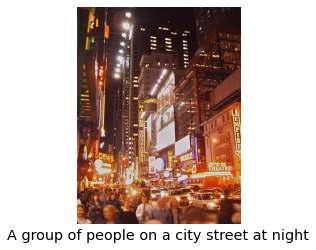

In [5]:
# Add your Computer Vision subscription key and endpoint to your environment variables.
#if 'COMPUTER_VISION_SUBSCRIPTION_KEY' in os.environ:
#    subscription_key = os.environ['COMPUTER_VISION_SUBSCRIPTION_KEY']
#elif 'COGNITIVE_SERVICE_KEY' in os.environ:
#    subscription_key = os.environ['COGNITIVE_SERVICE_KEY']    
#else:
#    print("\nSet the COMPUTER_VISION_SUBSCRIPTION_KEY or COGNITIVE_SERVICE_KEY environment variable.\n")
#
#if 'COMPUTER_VISION_ENDPOINT' in os.environ:
#    endpoint = os.environ['COMPUTER_VISION_ENDPOINT']
#else:
#    endpoint = "https://eastus.api.cognitive.microsoft.com/"

# Set image_url to the URL of an image that you want to analyze.
image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/1/12/" + \
    "Broadway_and_Times_Square_by_night.jpg/450px-Broadway_and_Times_Square_by_night.jpg"

headers = {'Ocp-Apim-Subscription-Key': subscription_key}
params = {'visualFeatures': 'Categories,Description,Color'}
#params = {'visualFeatures': 'Color,Categories'} 
data = {'url': image_url}
response = requests.post(analyze_url, headers=headers,
                         params=params, json=data)
response.raise_for_status()

# The 'analysis' object contains various fields that describe the image. The most
# relevant caption for the image is obtained from the 'description' property.
analysis = response.json()
print(json.dumps(response.json()))
image_caption = analysis["description"]["captions"][0]["text"].capitalize()

# Display the image and overlay it with the caption.
image = Image.open(BytesIO(requests.get(image_url).content))
plt.imshow(image)
plt.axis("off")
_ = plt.title(image_caption, size="x-large", y=-0.1)
plt.show()

In [6]:
def processRequest(json_, data, headers, params ):

    """
    Helper function to process the request to Project Oxford

    Parameters:
    json: Used when processing images from its URL. See API Documentation
    data: Used when processing image read from disk. See API Documentation
    headers: Used to pass the key information and the data type request
    """

    retries = 0
    result = None

    while True:

        response = requests.request( 'post', _url, json = json_, data = data, headers = headers, params = params )
        #response = requests.post(_url, headers=headers, params=params, json=json)

        if response.status_code == 429: 

            print( "Message: %s" % ( response.json()['error']['message'] ) )

            if retries <= _maxNumRetries: 
                time.sleep(1) 
                retries += 1
                continue
            else: 
                print( 'Error: failed after retrying!' )
                break

        elif response.status_code == 200 or response.status_code == 201:

            if 'content-length' in response.headers and int(response.headers['content-length']) == 0: 
                result = None 
            elif 'content-type' in response.headers and isinstance(response.headers['content-type'], str): 
                if 'application/json' in response.headers['content-type'].lower(): 
                    result = response.json() if response.content else None 
                elif 'image' in response.headers['content-type'].lower(): 
                    result = response.content
        else:
            print( "Error code: %d" % ( response.status_code ) )
            print( "Message: %s" % ( response.json()['error']['message'] ) )

        break
        
    return result

In [7]:
def renderResultOnImage( result, img ):
    
    """Display the obtained results onto the input image"""

    R = int(result['color']['accentColor'][:2],16)
    G = int(result['color']['accentColor'][2:4],16)
    B = int(result['color']['accentColor'][4:],16)

    cv2.rectangle( img,(0,0), (img.shape[1], img.shape[0]), color = (R,G,B), thickness = 25 )

    if 'categories' in result:
        categoryName = sorted(result['categories'], key=lambda x: x['score'])[0]['name']
        cv2.putText( img, categoryName, (30,70), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 3 )

{'categories': [{'name': 'animal_cat', 'score': 0.99609375}], 'color': {'dominantColorForeground': 'White', 'dominantColorBackground': 'White', 'dominantColors': ['White', 'Brown', 'Green'], 'accentColor': 'C30823', 'isBwImg': False, 'isBWImg': False}, 'description': {'tags': ['cat', 'indoor', 'laying', 'sitting', 'lying', 'small', 'orange', 'blanket', 'brown', 'bed', 'wearing', 'stuffed', 'basket', 'pair', 'shoes', 'sleeping', 'green', 'table'], 'captions': [{'text': 'a cat lying on a blanket', 'confidence': 0.9306895779208453}]}, 'requestId': '769a0c1b-4c84-465d-8580-697d7fdccbe5', 'metadata': {'height': 800, 'width': 1280, 'format': 'Jpeg'}}


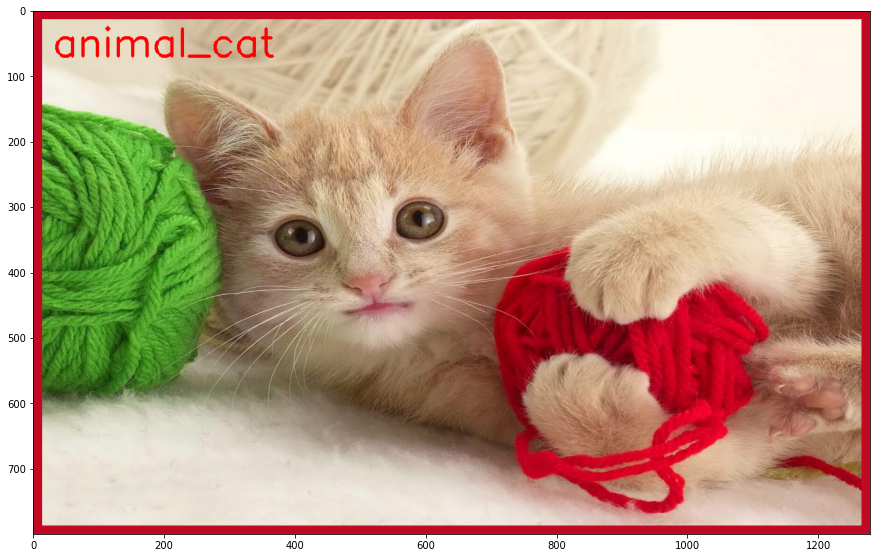

In [8]:
# URL direction to image
#urlImage = 'https://oxfordportal.blob.core.windows.net/vision/Analysis/3.jpg'
urlImage = 'http://wallpaperart.altervista.org/Immagini/gattino-che-gioca-1280x800.jpg' # kittens

#headers = {'Ocp-Apim-Subscription-Key': subscription_key}
#params = {'visualFeatures': 'Categories,Description,Color'}
#data = {'url': urlImage}
#response = requests.post(analyze_url, headers=headers,
#                         params=params, json=data)
#response.raise_for_status()

# The 'analysis' object contains various fields that describe the image. The most
# relevant caption for the image is obtained from the 'description' property.
#analysis = response.json()
#print(json.dumps(response.json()))
#image_caption = analysis["description"]["captions"][0]["text"].capitalize()

# Computer Vision parameters
#params = { 'visualFeatures' : 'Color,Categories'} 
params = {'visualFeatures': 'Categories,Description,Color'}

headers = dict()
headers['Ocp-Apim-Subscription-Key'] = subscription_key
headers['Content-Type'] = 'application/json' 

json_ = {'url': urlImage } 
data = None
#data = { 'url': urlImage } 

result = processRequest(json_, data, headers, params )

print(result)

if result is not None:
    # Load the original image, fetched from the URL
    arr = np.asarray( bytearray( requests.get( urlImage ).content ), dtype=np.uint8 )
    img = cv2.cvtColor( cv2.imdecode( arr, -1 ), cv2.COLOR_BGR2RGB )

    renderResultOnImage( result, img )

    ig, ax = plt.subplots(figsize=(15, 20))
    ax.imshow( img )

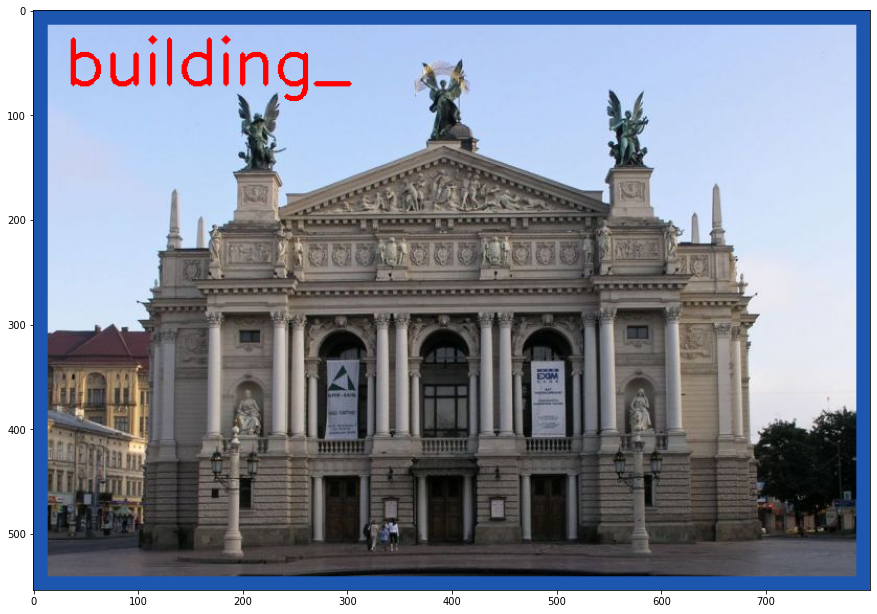

In [9]:
# Load raw image file into memory

pathToFileInDisk = 'lviv.jpg' #  path to image on your computer

with open(pathToFileInDisk, 'rb' ) as f:
    data = f.read()
    
# Computer Vision parameters
params = { 'visualFeatures' : 'Color,Categories'} 

headers = dict()
headers['Ocp-Apim-Subscription-Key'] = subscription_key
headers['Content-Type'] = 'application/octet-stream'

json_ = None

result = processRequest(json_, data, headers, params )

if result is not None:
    # Load the original image, fetched from the URL
    data8uint = np.frombuffer( data, np.uint8 ) # Convert string to an unsigned int array
    img = cv2.cvtColor( cv2.imdecode( data8uint, cv2.IMREAD_COLOR ), cv2.COLOR_BGR2RGB )

    renderResultOnImage( result, img )

    ig, ax = plt.subplots(figsize=(15, 20))
    ax.imshow( img )

## Computer Vision client library

In [10]:
from azure.cognitiveservices.vision.computervision import ComputerVisionClient
# from azure.cognitiveservices.vision.computervision.models import TextOperationStatusCodes
# from azure.cognitiveservices.vision.computervision.models import TextRecognitionMode
from azure.cognitiveservices.vision.computervision.models import VisualFeatureTypes
from msrest.authentication import CognitiveServicesCredentials

from array import array

In [11]:
computervision_client = ComputerVisionClient(endpoint, CognitiveServicesCredentials(subscription_key))

In [12]:
def plt_show(image, title="", size = (12,10)):
    #function to plot images cleanly
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    rcParams['figure.figsize'] = size[0], size[1]
    plt.axis("off")
    plt.title(title)
    plt.imshow(image, cmap="Greys_r")
    plt.show()

In [13]:
remote_image_url = "https://raw.githubusercontent.com/Azure-Samples/cognitive-services-sample-data-files/master/ComputerVision/Images/landmark.jpg"

#### Get image description
The following code gets the list of generated captions for the image. See [Describe images](https://docs.microsoft.com/en-us/azure/cognitive-services/computer-vision/concept-describing-images) for more details.

In [14]:
'''
Describe an Image - remote
This example describes the contents of an image with the confidence score.
'''
print("===== Describe an image - remote =====")
# Call API
description_results = computervision_client.describe_image(remote_image_url )

# Get the captions (descriptions) from the response, with confidence level
print("Description of remote image: ")
if (len(description_results.captions) == 0):
    print("No description detected.")
else:
    for caption in description_results.captions:
        print("'{}' with confidence {:.2f}%".format(caption.text, caption.confidence * 100))

===== Describe an image - remote =====
Description of remote image: 
'a castle on top of Colosseum' with confidence 86.02%


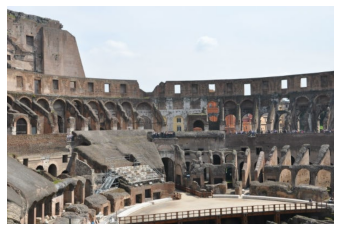

In [15]:
image = Image.open(BytesIO(requests.get(remote_image_url).content))

plt.imshow(image)
plt.axis("off")
plt.show()

#### Get image category
The following code gets the detected category of the image. See [Categorize images](https://docs.microsoft.com/en-us/azure/cognitive-services/computer-vision/concept-categorizing-images) for more details.

In [16]:
'''
Categorize an Image - remote
This example extracts (general) categories from a remote image with a confidence score.
'''
print("===== Categorize an image - remote =====")
# Select the visual feature(s) you want.
remote_image_features = ["categories"]
# Call API with URL and features
categorize_results_remote = computervision_client.analyze_image(remote_image_url , remote_image_features)

# Print results with confidence score
print("Categories from remote image: ")
if (len(categorize_results_remote.categories) == 0):
    print("No categories detected.")
else:
    for category in categorize_results_remote.categories:
        print("'{}' with confidence {:.2f}%".format(category.name, category.score * 100))

===== Categorize an image - remote =====
Categories from remote image: 
'building_' with confidence 31.64%
'others_' with confidence 0.39%
'outdoor_' with confidence 3.91%


#### Get image tags
The following code gets the set of detected tags in the image. See [Content tags](https://docs.microsoft.com/en-us/azure/cognitive-services/computer-vision/concept-tagging-images) for more details.

In [17]:
'''
Tag an Image - remote
This example returns a tag (key word) for each thing in the image.
'''
print("===== Tag an image - remote =====")
# Call API with remote image
tags_result_remote = computervision_client.tag_image(remote_image_url )

# Print results with confidence score
print("Tags in the remote image: ")
if (len(tags_result_remote.tags) == 0):
    print("No tags detected.")
else:
    for tag in tags_result_remote.tags:
        print("'{}' with confidence {:.2f}%".format(tag.name, tag.confidence * 100))

===== Tag an image - remote =====
Tags in the remote image: 
'building' with confidence 99.92%
'outdoor' with confidence 97.66%
'sky' with confidence 93.79%
'ruins' with confidence 76.13%
'amphitheatre' with confidence 56.34%


#### Detect objects
The following code detects common objects in the image and prints them to the console. See [Object detection](https://docs.microsoft.com/en-us/azure/cognitive-services/computer-vision/concept-object-detection) for more details.

In [18]:
'''
Detect Objects - remote
This example detects different kinds of objects with bounding boxes in a remote image.
'''
print("===== Detect Objects - remote =====")
# Get URL image with different objects
remote_image_url_objects = "https://raw.githubusercontent.com/Azure-Samples/cognitive-services-sample-data-files/master/ComputerVision/Images/objects.jpg"
# Call API with URL
detect_objects_results_remote = computervision_client.detect_objects(remote_image_url_objects)

# Print detected objects results with bounding boxes
print("Detecting objects in remote image:")
if len(detect_objects_results_remote.objects) == 0:
    print("No objects detected.")
else:
    for object in detect_objects_results_remote.objects:
        print("object at location {}, {}, {}, {}".format( \
        object.rectangle.x, object.rectangle.x + object.rectangle.w, \
        object.rectangle.y, object.rectangle.y + object.rectangle.h))

===== Detect Objects - remote =====
Detecting objects in remote image:
object at location 213, 365, 85, 208
object at location 218, 402, 179, 384
object at location 238, 417, 298, 416
object at location 116, 419, 60, 386


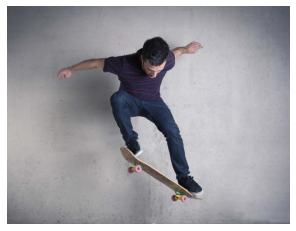

In [19]:
image = Image.open(BytesIO(requests.get(remote_image_url_objects).content))

plt.imshow(image)
plt.axis("off")
plt.show()

#### Detect brands
The following code detects corporate brands and logos in the image and prints them to the console. See [Brand detection](https://docs.microsoft.com/en-us/azure/cognitive-services/computer-vision/concept-brand-detection) for more details.

In [20]:
'''
Detect Brands - remote
This example detects common brands like logos and puts a bounding box around them.
'''
print("===== Detect Brands - remote =====")
# Get a URL with a brand logo
remote_image_url_brands = "https://docs.microsoft.com/en-us/azure/cognitive-services/computer-vision/images/gray-shirt-logo.jpg"
# Select the visual feature(s) you want
remote_image_features = ["brands"]
# Call API with URL and features
detect_brands_results_remote = computervision_client.analyze_image(remote_image_url_brands, remote_image_features)

print("Detecting brands in remote image: ")
if len(detect_brands_results_remote.brands) == 0:
    print("No brands detected.")
else:
    for brand in detect_brands_results_remote.brands:
        print("'{}' brand detected with confidence {:.1f}% at location {}, {}, {}, {}".format( \
        brand.name, brand.confidence * 100, brand.rectangle.x, brand.rectangle.x + brand.rectangle.w, \
        brand.rectangle.y, brand.rectangle.y + brand.rectangle.h))

===== Detect Brands - remote =====
Detecting brands in remote image: 
'Microsoft' brand detected with confidence 62.5% at location 58, 113, 106, 152
'Microsoft' brand detected with confidence 69.8% at location 58, 260, 86, 149


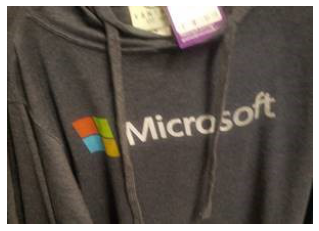

In [21]:
image = Image.open(BytesIO(requests.get(remote_image_url_brands).content))

plt.imshow(image)
plt.axis("off")
plt.show()

#### Detect faces
The following code returns the detected faces in the image with their rectangle coordinates and select face attributes. See [Face detection](https://docs.microsoft.com/en-us/azure/cognitive-services/computer-vision/concept-detecting-faces) for more details.

In [22]:
'''
Detect Faces - remote
This example detects faces in a remote image, gets their gender and age, 
and marks them with a bounding box.
'''

print("===== Detect Faces - remote =====")
# Get an image with faces
remote_image_url_faces = "https://raw.githubusercontent.com/Azure-Samples/cognitive-services-sample-data-files/master/ComputerVision/Images/faces.jpg"
# Select the visual feature(s) you want.
remote_image_features = ["faces"]
# Call the API with remote URL and features
detect_faces_results_remote = computervision_client.analyze_image(remote_image_url_faces, remote_image_features)

# Print the results with gender, age, and bounding box
print("Faces in the remote image: ")
if (len(detect_faces_results_remote.faces) == 0):
    print("No faces detected.")
else:
    for face in detect_faces_results_remote.faces:
        print("'{}' of age {} at location {}, {}, {}, {}".format(face.gender, face.age, \
        face.face_rectangle.left, face.face_rectangle.top, \
        face.face_rectangle.left + face.face_rectangle.width, \
        face.face_rectangle.top + face.face_rectangle.height))

===== Detect Faces - remote =====
Faces in the remote image: 
'Male' of age 39 at location 118, 159, 212, 253
'Male' of age 54 at location 492, 111, 582, 201
'Female' of age 55 at location 18, 153, 102, 237
'Female' of age 33 at location 386, 166, 467, 247
'Female' of age 18 at location 235, 158, 311, 234
'Female' of age 8 at location 323, 163, 391, 231


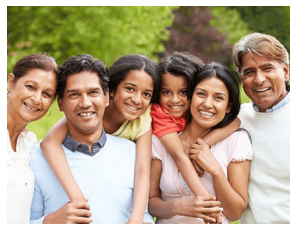

In [23]:
image = Image.open(BytesIO(requests.get(remote_image_url_faces).content))

plt.imshow(image)
plt.axis("off")
plt.show()

#### Detect adult, racy, or gory content
The following code prints the detected presence of adult content in the image. See [Adult, racy, gory content](https://docs.microsoft.com/en-us/azure/cognitive-services/computer-vision/concept-detecting-adult-content) for more details.

In [24]:
'''
Detect Adult or Racy Content - remote
This example detects adult or racy content in a remote image, then prints the adult/racy score.
The score is ranged 0.0 - 1.0 with smaller numbers indicating negative results.
'''
print("===== Detect Adult or Racy Content - remote =====")
# Select the visual feature(s) you want
remote_image_features = ["adult"]
# Call API with URL and features
detect_adult_results_remote = computervision_client.analyze_image(remote_image_url_brands, remote_image_features)

# Print results with adult/racy score
print("Analyzing remote image for adult or racy content ... ")
print("Is adult content: {} with confidence {:.2f}".format(detect_adult_results_remote.adult.is_adult_content, detect_adult_results_remote.adult.adult_score * 100))
print("Has racy content: {} with confidence {:.2f}".format(detect_adult_results_remote.adult.is_racy_content, detect_adult_results_remote.adult.racy_score * 100))

===== Detect Adult or Racy Content - remote =====
Analyzing remote image for adult or racy content ... 
Is adult content: False with confidence 0.52
Has racy content: False with confidence 1.35


#### Get domain-specific content
Computer Vision can use specialized model to do further analysis on images. See [Domain-specific content](https://docs.microsoft.com/en-us/azure/cognitive-services/computer-vision/concept-detecting-domain-content) for more details.

The following code parses data about detected celebrities in the image.

In [25]:
'''
Detect Domain-specific Content - remote
This example detects celebrites and landmarks in remote images.
'''
print("===== Detect Domain-specific Content - remote =====")
# URL of one or more celebrities
remote_image_url_celebs = "https://raw.githubusercontent.com/Azure-Samples/cognitive-services-sample-data-files/master/ComputerVision/Images/faces.jpg"
# Call API with content type (celebrities) and URL
detect_domain_results_celebs_remote = computervision_client.analyze_image_by_domain("celebrities", remote_image_url_celebs)

# Print detection results with name
print("Celebrities in the remote image:")
if len(detect_domain_results_celebs_remote.result["celebrities"]) == 0:
    print("No celebrities detected.")
else:
    for celeb in detect_domain_results_celebs_remote.result["celebrities"]:
        print(celeb["name"])

===== Detect Domain-specific Content - remote =====
Celebrities in the remote image:
Bern Collaco


The following code parses data about detected landmarks in the image.

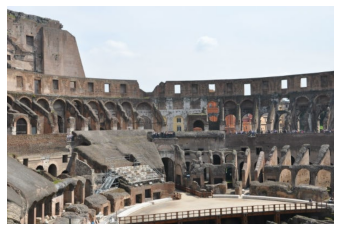

In [26]:
image = Image.open(BytesIO(requests.get(remote_image_url).content))

plt.imshow(image)
plt.axis("off")
plt.show()

In [27]:
# Call API with content type (landmarks) and URL
detect_domain_results_landmarks = computervision_client.analyze_image_by_domain("landmarks", remote_image_url)
print()

print("Landmarks in the remote image:")
if len(detect_domain_results_landmarks.result["landmarks"]) == 0:
    print("No landmarks detected.")
else:
    for landmark in detect_domain_results_landmarks.result["landmarks"]:
        print(landmark["name"])


Landmarks in the remote image:
Colosseum


### Read printed and handwritten text
Computer Vision can read visible text in an image and convert it to a character stream. You do this in two parts.

#### Call the Read API
First, use the following code to call the __batch_read_file__ method for the given image. This returns an operation ID and starts an asynchronous process to read the content of the image.

In [28]:
# '''
# Batch Read File, recognize printed text - remote
# This example will extract printed text in an image, then print results, line by line.
# This API call can also recognize handwriting (not shown).
# '''
# print("===== Batch Read File - remote =====")
# # Get an image with printed text
# remote_image_printed_text_url = "https://raw.githubusercontent.com/Azure-Samples/cognitive-services-sample-data-files/master/ComputerVision/Images/printed_text.jpg"

# # Call API with URL and raw response (allows you to get the operation location)
# recognize_printed_results = computervision_client.batch_read_file(remote_image_printed_text_url,  raw=True)

#### Get Read results
Next, get the operation ID returned from the __batch_read_file__ call, and use it to query the service for operation results. The following code checks the operation at one-second intervals until the results are returned. It then prints the extracted text data to the console.

In [29]:
# # Get the operation location (URL with an ID at the end) from the response
# operation_location_remote = recognize_printed_results.headers["Operation-Location"]
# # Grab the ID from the URL
# operation_id = operation_location_remote.split("/")[-1]

# # Call the "GET" API and wait for it to retrieve the results 
# while True:
#     get_printed_text_results = computervision_client.get_read_operation_result(operation_id)
#     if get_printed_text_results.status not in ['NotStarted', 'Running']:
#         break
#     time.sleep(1)

# # Print the detected text, line by line
# if get_printed_text_results.status == TextOperationStatusCodes.succeeded:
#     for text_result in get_printed_text_results.recognition_results:
#         for line in text_result.lines:
#             print(line.text)
#             print(line.bounding_box)
# print()

In [30]:
# image = Image.open(BytesIO(requests.get(remote_image_printed_text_url).content))
# plt.imshow(image); plt.axis("off"); plt.show()

## Text Analytics Cognitive Service

#### Detect languages
Append `/text/analytics/v2.1/languages` to the Text Analytics base endpoint to form the language detection URL.

In [31]:
language_api_url = f"{endpoint}/text/analytics/v2.1/languages"

The payload to the API consists of a list of `documents`, which are tuples containing an `id` and a `text` attribute. The `text` attribute stores the text to be analyzed, and the `id` can be any value.

In [32]:
documents = {"documents": [
    {"id": "1", "text": "This is a document written in English."},
    {"id": "2", "text": "Este es un document escrito en Español."},
    {"id": "3", "text": "这是一个用中文写的文件"},
    {"id": "4", "text": "Разом ми сила."}
]}

Use the Requests library to send the documents to the API. Add your subscription key to the `Ocp-Apim-Subscription-Key` header, and send the request with `requests.post()`.

In [33]:
headers = {"Ocp-Apim-Subscription-Key": subscription_key}
response = requests.post(language_api_url, headers=headers, json=documents)

languages = response.json()
pprint(languages)

{'documents': [{'detectedLanguages': [{'iso6391Name': 'en',
                                       'name': 'English',
                                       'score': 1.0}],
                'id': '1'},
               {'detectedLanguages': [{'iso6391Name': 'es',
                                       'name': 'Spanish',
                                       'score': 1.0}],
                'id': '2'},
               {'detectedLanguages': [{'iso6391Name': 'zh_chs',
                                       'name': 'Chinese_Simplified',
                                       'score': 1.0}],
                'id': '3'},
               {'detectedLanguages': [{'iso6391Name': 'uk',
                                       'name': 'Ukrainian',
                                       'score': 1.0}],
                'id': '4'}],
 'errors': []}


#### Analyze sentiment
To detect the sentiment (which ranges between positive or negative) of a set of documents, append `/text/analytics/v2.1/sentiment` to the Text Analytics base endpoint to form the language detection URL.

In [34]:
sentiment_url = f"{endpoint}/text/analytics/v2.1/sentiment"

As with the language detection example, create a dictionary with a documents key that consists of a list of `documents`. Each document is a tuple consisting of the `id`, the `text` to be analyzed and the `language` of the text.

In [35]:
documents = {"documents": [
    {"id": "1", "language": "en",
        "text": "I had a wonderful experience! The rooms were wonderful and the staff was helpful."},
    {"id": "2", "language": "en",
        "text": "I had a terrible time at the hotel. The staff was rude and the food was awful."},
    {"id": "3", "language": "es",
        "text": "Los caminos que llevan hasta Monte Rainier son espectaculares y hermosos."},
    {"id": "4", "language": "es",
     "text": "La carretera estaba atascada. Había mucho tráfico el día de ayer."},
    {"id": "5", "language": "ru",
     "text": "Куда прешься балбес. Ты сейчас у меня получишь."},
    {"id": "6", "language": "uk",
     "text": "Людоньки, шо це коїться. Це просто жах."}
]}

Use the Requests library to send the documents to the API. Add your subscription key to the `Ocp-Apim-Subscription-Key` header, and send the request with `requests.post()`.

In [36]:
headers = {"Ocp-Apim-Subscription-Key": subscription_key}
response = requests.post(sentiment_url, headers=headers, json=documents)

sentiments = response.json()
pprint(sentiments)

{'documents': [{'id': '1', 'score': 0.9734485149383545},
               {'id': '2', 'score': 6.207823753356934e-05},
               {'id': '3', 'score': 0.7456425428390503},
               {'id': '4', 'score': 0.334433376789093},
               {'id': '5', 'score': 0.42637088894844055}],
 'errors': [{'id': '6',
             'message': 'Supplied language is not supported. Pass in one of: '
                        'ar,da,de,el,en,es,fi,fr,it,ja,nl,no,pl,pt-PT,ru,sv,tr,zh-Hans. '
                        'See '
                        'https://docs.microsoft.com/en-us/azure/cognitive-services/text-analytics/overview '
                        'for the complete list of support languages.'}]}


#### Extract key phrases
To extract the key phrases from a set of documents, append `/text/analytics/v2.1/keyPhrases` to the Text Analytics base endpoint to form the language detection URL.

In [37]:
keyphrase_url = f"{endpoint}/text/analytics/v2.1/keyphrases"

In [38]:
documents = {"documents": [
    {"id": "1", "language": "en",
        "text": "I had a wonderful experience! The rooms were wonderful and the staff was helpful."},
    {"id": "2", "language": "en",
        "text": "I had a terrible time at the hotel. The staff was rude and the food was awful."},
    {"id": "3", "language": "es",
        "text": "Los caminos que llevan hasta Monte Rainier son espectaculares y hermosos."},
    {"id": "4", "language": "es",
     "text": "La carretera estaba atascada. Había mucho tráfico el día de ayer."}
]}

In [39]:
headers = {"Ocp-Apim-Subscription-Key": subscription_key}
response = requests.post(keyphrase_url, headers=headers, json=documents)

key_phrases = response.json()
pprint(key_phrases)

{'documents': [{'id': '1',
                'keyPhrases': ['wonderful experience', 'staff', 'rooms']},
               {'id': '2',
                'keyPhrases': ['food', 'terrible time', 'hotel', 'staff']},
               {'id': '3', 'keyPhrases': ['Monte Rainier', 'caminos']},
               {'id': '4', 'keyPhrases': ['carretera', 'tráfico', 'día']}],
 'errors': []}


#### Identify Entities
To identify well-known entities (people, places, and things) in text documents, append `/text/analytics/v2.1/entities` to the Text Analytics base endpoint to form the language detection URL.

In [40]:
entities_url = f"{endpoint}/text/analytics/v2.1/entities"

In [41]:
documents = {"documents": [
    {"id": "1", "text": "Microsoft was founded by Bill Gates and Paul Allen on April 4, 1975, to develop and sell BASIC interpreters for the Altair 8800."}
]}

In [42]:
headers = {"Ocp-Apim-Subscription-Key": subscription_key}
response = requests.post(entities_url, headers=headers, json=documents)

entities = response.json()
pprint(entities)

{'documents': [{'entities': [{'bingId': 'a093e9b9-90f5-a3d5-c4b8-5855e1b01f85',
                              'matches': [{'entityTypeScore': 1.0,
                                           'length': 9,
                                           'offset': 0,
                                           'text': 'Microsoft',
                                           'wikipediaScore': 0.5080587142195991}],
                              'name': 'Microsoft',
                              'type': 'Organization',
                              'wikipediaId': 'Microsoft',
                              'wikipediaLanguage': 'en',
                              'wikipediaUrl': 'https://en.wikipedia.org/wiki/Microsoft'},
                             {'bingId': '0d47c987-0042-5576-15e8-97af601614fa',
                              'matches': [{'entityTypeScore': 1.0,
                                           'length': 10,
                                           'offset': 25,
                       

## Language Understanding (LUIS)

For this part, you need to understand what is entities and intents in natural language processing means. In general, LUIS provides a easy platform for you to train language understanding models based on limited examples provided.

In [43]:
import luis

For the key and endpoint, please visit [LUIS API](http://luis.ai) to obtain one. Before you could use this function, you need to:

1. Set up Entities list and Intents list (by giving examples) after constructing the API. (Remember to click on train to update the model). An untrained API will always return 'None' but you could still get 'sentiment analysis' score.

2. Before you test the following code, you need to publish your API and make endpoints public. Select publish and turn on 'Sentiment analysis' 'Bing spell check' and 'Speech priming' at 'Production' level. Unpublished API will return an error when the following requests are processed.

3. Every time after you change the training of API (including adding examples and changing entities etc.) you will need to publish your API at prodcution level again to reflect the update.

Please note that your "@mail.utoronto.ca" and other organization email accounts might not be allowed to access LUIS at this moment.

In [47]:
try:
    key = subscription_key
    endpoint = 'https://intro-to-ds-cs.cognitiveservices.azure.com/' #such as 'https://xxxxx(server_location).api.cognitive.microsoft.com/' 
    appId = os.environ['APP_ID'] #such as 'xxxxxxxx-xxxx-xxxx-xxxx-xxxxxxxxxxxx'

    # To get the same result, you need to train your own API with similar exmaples first. 
    
    # The training examples for this toy model is provided below:
    
    utterance = 'I really like MIE1624 this semester! I am thinking of taking a career in data science in future.'

    headers = {
    }

    params ={
        'query': utterance,
        'timezoneOffset': '0',
        'verbose': 'true',
        'show-all-intents': 'true',
        'spellCheck': 'false',
        'staging': 'false',
        'subscription-key': key
    }

    #r = requests.get(f'https://{endpoint}luis/prediction/v3.0/apps/{appId}/slots/production/predict',headers=headers, params=params)
    r = requests.get(f'{endpoint}luis/prediction/v3.0/apps/{appId}/slots/production/predict',headers=headers, params=params)    
    print(r.json())

except Exception as e:
    print(f'{e}')

{'query': 'I really like MIE1624 this semester! I am thinking of taking a career in data science in future.', 'prediction': {'topIntent': 'future plan', 'intents': {'future plan': {'score': 0.6153221}, 'comment of a course': {'score': 0.3686398}, 'None': {'score': 0.0208373722}}, 'entities': {}, 'sentiment': {'label': 'positive', 'score': 0.9140061}}}


Examples used in this toy example:

Intent: 'comment of a course':

    - i fell like wishing to take this course again
    - course has too much assignments!
    - csc001 is a brilliant course
    - this course is just so so

Intent: 'future plan'

    - have a plan to seek job in this summer
    - next year i will take another similar course
    - i want to graduate soon

No entities is trained.

Some other example based on this toy model:

In [48]:
utterance = 'This sentense is just a sentence'
headers = {
    }
params ={
        'query': utterance,
        'timezoneOffset': '0',
        'verbose': 'true',
        'show-all-intents': 'true',
        'spellCheck': 'false',
        'staging': 'false',
        'subscription-key': key
    }

r = requests.get(f'{endpoint}luis/prediction/v3.0/apps/{appId}/slots/production/predict',headers=headers, params=params)    
print(r.json())

{'query': 'This sentense is just a sentence', 'prediction': {'topIntent': 'comment of a course', 'intents': {'comment of a course': {'score': 0.329352021}, 'future plan': {'score': 0.127451852}, 'None': {'score': 0.0563302673}}, 'entities': {}, 'sentiment': {'label': 'positive', 'score': 0.81307137}}}


In [49]:
utterance = 'This course is interesting with lots of good tutorials and examples.'
headers = {
    }
params ={
        'query': utterance,
        'timezoneOffset': '0',
        'verbose': 'true',
        'show-all-intents': 'true',
        'spellCheck': 'false',
        'staging': 'false',
        'subscription-key': key
    }

r = requests.get(f'{endpoint}luis/prediction/v3.0/apps/{appId}/slots/production/predict',headers=headers, params=params)    
print(r.json())

{'query': 'This course is interesting with lots of good tutorials and examples.', 'prediction': {'topIntent': 'comment of a course', 'intents': {'comment of a course': {'score': 0.6306198}, 'future plan': {'score': 0.345047444}, 'None': {'score': 0.015090609}}, 'entities': {}, 'sentiment': {'label': 'positive', 'score': 0.962418437}}}


In [50]:
utterance = 'Next year, I will read a interesting story every day.'
headers = {
    }
params ={
        'query': utterance,
        'timezoneOffset': '0',
        'verbose': 'true',
        'show-all-intents': 'true',
        'spellCheck': 'false',
        'staging': 'false',
        'subscription-key': key
    }

r = requests.get(f'{endpoint}luis/prediction/v3.0/apps/{appId}/slots/production/predict',headers=headers, params=params)    
print(r.json())

{'query': 'Next year, I will read a interesting story every day.', 'prediction': {'topIntent': 'future plan', 'intents': {'future plan': {'score': 0.8051036}, 'comment of a course': {'score': 0.1114919}, 'None': {'score': 0.022414621}}, 'entities': {'datetimeV2': [{'type': 'daterange', 'values': [{'timex': '2021', 'resolution': [{'start': '2021-01-01', 'end': '2022-01-01'}]}]}, {'type': 'set', 'values': [{'timex': 'P1D', 'resolution': [{'value': 'not resolved'}]}]}], '$instance': {'datetimeV2': [{'type': 'builtin.datetimeV2.daterange', 'text': 'Next year', 'startIndex': 0, 'length': 9, 'modelTypeId': 2, 'modelType': 'Prebuilt Entity Extractor', 'recognitionSources': ['model']}, {'type': 'builtin.datetimeV2.set', 'text': 'every day', 'startIndex': 43, 'length': 9, 'modelTypeId': 2, 'modelType': 'Prebuilt Entity Extractor', 'recognitionSources': ['model']}]}}, 'sentiment': {'label': 'positive', 'score': 0.975793958}}}


Here is a short guide on training entities and intents.

1. For entities, there are several different types:

    1. A simple entity describes a single concept. For example, if the user's intent is GetWeather, you can use City as a simple entity to capture the city for the weather report.
    2. Use a composite entity to represent an object that has parts. The composite entity is made up of entities that form the whole. For example, a composite entity called TicketsOrder in a travel app can be composed of three child entities that describe attributes of the tickets to order: Number, PassengerCategory and TravelClass.
    3. A list entity is a fixed list of values. Each value is itself a list of synonyms or other forms the value may take. For example, a list entity named PacificStates include the values Washington, Oregon, California. The Washington value then includes both "Washington" and the abbreviation "WA". Unlike other entity types, additional values for list entities aren't discovered during training. This entity type is identified in utterances by the direct matching of utterance text to the defined values, rather than learning from context.
    4. A regex entity is an entity that matches based on the regular expression defined. Regex entities are not machine learned entities.
    5. A pattern entity is a variable-length placeholder used only in a pattern's template utterance to mark where the entity begins and ends.
    
2. For intents:
    1. Give adequate number of examples in each intent,
    2. Combining intents detection and entities detection could be considered to imrpove performance.

Clear your own credentials before sharing this notebook:

In [69]:
#subscription_key = 'PLEASE_ENTER_YOUR_OWN_SUBSCRIPTION_KEY'
#endpoint = 'PLEASE_ENTER_YOUR_ENDPOINT_URL'
#key = 'PLEASE_ENTER_YOUR_LUIS_SUBSCRIPTION_KEY'
#endpoint = 'PLEASE_ENTER_YOUR_ENDPOINT_URL'
#appId = 'PLEASE_ENTER_YOUR_LUIS_APPID'